In [2]:
# import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
from gurobipy import *
import pandas

# read the data and set the random seed
excel_data_df = pandas.read_excel('台灣景點經緯度.xlsx')
np.random.seed(2)

# some parameters
city_num = 14  #  here we show the number of city
r1 = 0.7  # prob of pbest-xi 
r2 = 0.8  # prob of gbest-xi 
iter_num = 1000  # the max iteration number
fitneess_value_list = []  # fintness value list

# here we record the data
Z = []
X = []
Y = []
for i in range(city_num):
    Z.append(excel_data_df['經緯度（十進位度數 (DD)）'][i])
    X.append(float(Z[i].split(', ')[0]))
    Y.append(float(Z[i].split(', ')[1]))



In [3]:
# here we show the function that we count the distance of x, and y 
def calculate_distance(X, Y):
    distance_matrix = np.zeros((city_num, city_num))
    for i in range(city_num):
        for j in range(city_num):
            if i == j:
                continue
            dis = np.sqrt((X[i] - X[j]) ** 2 + (Y[i] - Y[j]) ** 2)  # count the distance
            distance_matrix[i][j] = dis
    return distance_matrix
# here we record the all subsets
def get_children(lt_N):
    n = len(lt_N)
    result = []
    for i in range(2 ** n):  # Number of subsets, one subset per cycle
        combo = []
        for j in range(n):  # Used to determine whether the number of positions in binary subscript j is 1
            if(i >> j) % 2:
                combo.append(lt_N[j])
        result.append(combo)
    return result


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-29
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 8220 rows, 197 columns and 373311 nonzeros
Model fingerprint: 0x3279ea03
Variable types: 1 continuous, 196 integer (196 binary)
Coefficient statistics:
  Matrix range     [7e-02, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 12.7158110
Presolve removed 14 rows and 14 columns
Presolve time: 0.34s
Presolved: 8206 rows, 183 columns, 319854 nonzeros
Variable types: 0 continuous, 183 integer (183 binary)

Root relaxation: objective 5.887990e+00, 52 iterations, 0.09 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  

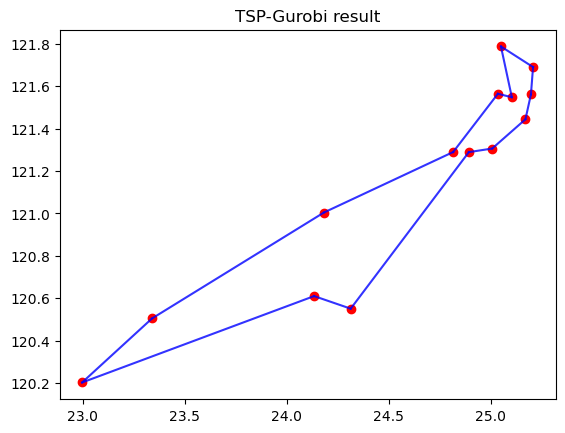

In [4]:
V = [i for i in range(city_num)] # Urban collection
D = calculate_distance(X, Y)    #Calculate the distance between cities
D_ij = list(D)                  # to a list

t_start = time.process_time()         #start to record the time

md = Model('TSP_1')               # create the model
x_ij = md.addVars(city_num, city_num, vtype=GRB.BINARY,name='X')    #create the variables
Makespan = md.addVar(lb=0, name='Makespan', vtype=GRB.CONTINUOUS)   #create objective variables

md.addConstrs(x_ij.sum(i,'*') == 1 for i in V)  #Constraint 1, make sure there's a only way out
md.addConstrs(x_ij.sum('*',j) == 1 for j in V)  #Constraint 2, make sure there is a unique entry

V_children = get_children(V[1:])            #Get the sum of all subsets
for v in V_children:
    if len(v) > 0:
        md.addConstr(sum(x_ij[i,j] for i in v for j in v) <= len(v) - 1)    #Constraint 3, to avoid the appearance of a soliton ring
md.addConstr(Makespan == sum(D_ij[i][j] * x_ij[i,j] for i in V for j in V if i != j)) #The constraint on the value of the target function
md.setObjective(Makespan,GRB.MINIMIZE)  #Minimum of the target function

md.optimize()   #Model of solution

t_finish = time.process_time() - t_start   #End of clock
# draw the chart
plt.scatter(X, Y, color='r')    #draw the points
result = []
for i in V:
    for j in V:
        if x_ij[i,j].x > 0:
            result.append((i,j))
            plt.plot([X[i],X[j]],[Y[i],Y[j]],color='b', alpha=0.8)  #draw the lines

gbest = [0]
index = 0
gbest[0] = result[0][0]
for i in V[1:]:
    gbest.append(result[index][1])
    index = gbest[-1]   #Unified output format with PSO

print('The optimal result of Gurobis solution is: ', md.objVal)
print('The optimal variable for Gurobi is：', gbest)    #print the result
print('Gurobi takes time to solve: ', t_finish)
plt.title('TSP-Gurobi result') 
# show the plot
plt.show()
 
